# Ternary Multiplication in Triton

## Setup

In [37]:
%pip install --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly==3.0.0.post20240626041721

Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [38]:
import os

os.environ["TRITON_PRINT_AUTOTUNING"] = "1"

Check the installed triton version.

In [39]:
import triton

assert triton.__version__ == "3.0.0", f"Expected Triton to have a version of 3.0.0, but found {triton.__version__}"

Import other needed stuff.

In [40]:
import warnings

import torch
import triton.language as tl

## Helper Functions

In [41]:
def get_current_target():
    return triton.runtime.driver.active.get_current_target()

In [42]:
def is_cuda():
    current_target = get_current_target()
    if current_target.backend != "cuda":
        return False

    if current_target.arch < 70:  # CUDA compute capacity is below 7.0, which is minimum 'stable' supported by Triton
        warnings.warn(
            "Compute capacity of CUDA device is below 7.0. The Triton compilation may fail terribly!", stacklevel=1
        )

    return True

## 2D Ternary Multiplication Kernel

First, define the autotune config for the kernel.

In [43]:
def _get_autotune_config_2d():
    return [
        triton.Config(
            {
                "BLOCK_SIZE_M": 2,
                "BLOCK_SIZE_N": 2,
            }
        )
    ]
    
    # return [
    #     triton.Config(
    #         {
    #             "BLOCK_SIZE_M": 256,
    #             "BLOCK_SIZE_N": 256,
    #         },
    #         num_stages=4,
    #         num_warps=4,
    #     ),
    #     triton.Config(
    #         {
    #             "BLOCK_SIZE_M": 128,
    #             "BLOCK_SIZE_N": 128,
    #         },
    #         num_stages=4,
    #         num_warps=4,
    #     ),
    #     triton.Config(
    #         {
    #             "BLOCK_SIZE_K": 128,
    #             "BLOCK_SIZE_N": 64,
    #         },
    #         num_stages=4,
    #         num_warps=4,
    #     ),
    #     triton.Config(
    #         {
    #             "BLOCK_SIZE_K": 64,
    #             "BLOCK_SIZE_N": 128,
    #         },
    #         num_stages=4,
    #         num_warps=4,
    #     ),
    #     triton.Config(
    #         {
    #             "BLOCK_SIZE_K": 128,
    #             "BLOCK_SIZE_N": 32,
    #         },
    #         num_stages=4,
    #         num_warps=4,
    #     ),
    #     triton.Config(
    #         {
    #             "BLOCK_SIZE_K": 32,
    #             "BLOCK_SIZE_N": 128,
    #         },
    #         num_stages=4,
    #         num_warps=4,
    #     ),
    #     triton.Config(
    #         {
    #             "BLOCK_SIZE_M": 64,
    #             "BLOCK_SIZE_N": 32,
    #         },
    #         num_stages=5,
    #         num_warps=2,
    #     ),
    #     triton.Config(
    #         {
    #             "BLOCK_SIZE_M": 32,
    #             "BLOCK_SIZE_N": 64,
    #         },
    #         num_stages=5,
    #         num_warps=2,
    #     )
    # ]

In [44]:
def get_autotune_config_2d():
    if is_cuda():
        return _get_autotune_config_2d()
    else:
        raise ValueError("Not on CUDA... can't use!")

Now we define the Triton kernel. The rough pseudocode algorithm is as follows.
```python
# Do in parallel
for n in range(0, N, BLOCK_SIZE_N):
    acc = zeros((BLOCK_SIZE_N,), dtype=float32)
    for m in range(0, M, BLOCK_SIZE_M):
        x_block = x[m : m+BLOCK_SIZE_M]
        w_block = w[m : m+BLOCK_SIZE_M, n : n+BLOCK_SIZE_N]
        
        # Since `w` is ternary, we only really care about the sign of the element in the array, and so
        # we just need to perform two conditional checks
        elems_to_sum = tl.where(w_block > 0, x_block, tl.where(w_block < 0, -x_block, tl.zeros_like(x_block)))
        acc += tl.sum(elems_to_sum)  # Sum along the M direction

    acc = acc / scale
    z[n : n+BLOCK_SIZE_N] = acc
```

In [45]:
# ruff: noqa: N803, PLR2044
@triton.autotune(
    configs=get_autotune_config_2d(),
    key=["M", "N"],
)
@triton.jit
def ternary_mul_2d_kernel(
    # Pointers to arrays
    x_ptr,
    w_ptr,
    z_ptr,
    # Scaling factor
    scale,
    # `W` matrix dimensions
    M,
    N,
    # The stride variables represent how much to increase the pointer by when moving by 1 element in a particular
    # dimension. E.g. `stride_wm` is how much to increase `w_ptr` by to get the element one row down (the `W` matrix
    # has `M` rows).
    stride_xm,
    stride_wm,
    stride_wn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
):
    """
    Kernel for computing the ternary multiplication
        z = xW
    `x` has shape `(M,)`, `W` has shape `(M, N)`, and `z` has shape `(N,)`.
    """

    # ----------------------------------------------------------
    # Create pointers for the first blocks of `x` and `W`.
    # We will advance this pointer as we move in the `M` direction and accumulate.
    # - `x_ptrs` is a block of `BLOCK_SIZE_M` pointers
    # - `w_ptrs` is a block of pointers with shape `(BLOCK_SIZE_M, BLOCK_SIZE_N)`
    pid_0 = tl.program_id(axis=0)

    offs_m = tl.arange(0, BLOCK_SIZE_M)
    offs_n = (pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N  # Guard against wrong offsets

    x_ptrs = x_ptr + offs_m
    w_ptrs = w_ptr + (offs_m[:, None] * stride_wm + offs_n[None, :] * stride_wn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the `z` vector.
    # We accumulate into a block of `BLOCK_SIZE_N` elements of FP32 values for higher accuracy.
    accumulator = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)
    for m in range(0, tl.cdiv(M, BLOCK_SIZE_M)):
        # Load the next block of `x` and `W`, generate a mask by checking along `M`.
        # If it is out of bounds, set it to 0.
        x = tl.load(x_ptrs, mask=offs_m < M - m * BLOCK_SIZE_M, other=0.0)[:, None]  # Force broadcast to correct shape
        w = tl.load(w_ptrs, mask=offs_m[:, None] < M - m * BLOCK_SIZE_M, other=0.0)

        # Since `w` is ternary, we only really care about the sign of the element in the array, and so
        # we just need to perform two conditional checks
        elements_to_sum = tl.where(w > 0, x, tl.where(w < 0, -x, tl.zeros_like(x)))
        accumulator = accumulator + tl.sum(elements_to_sum, axis=0)  # Sum along the `M` direction

        # Advance the ptrs to the next `M` block.
        x_ptrs += BLOCK_SIZE_M * stride_xm
        w_ptrs += BLOCK_SIZE_M * stride_wm

    z = accumulator / scale  # TODO: Do we want to reduce precision back to FP16?

    # -----------------------------------------------------------
    # Write back the block of the output vector `z` with masks.
    offs_z = pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    z_ptrs = z_ptr + offs_z
    z_mask = offs_z < N
    tl.store(z_ptrs, z, mask=z_mask)

/tmp/ipykernel_43485/3679571787.py:7: UserWarning: Compute capacity of CUDA device is below 7.0. The Triton compilation may fail terribly!
  warnings.warn(


Create a convenience wrapper function that handles the checks and kernel calling.

In [46]:
# ruff: noqa: E731, S101, N806
def ternary_mul_2d(x, w, scale):
    # Check constraints
    assert len(x) == w.shape[0], "Incompatible dimensions"
    assert x.is_contiguous(), "x must be contiguous"
    assert x.is_cuda and w.is_cuda

    # Get dimensions
    M, N = w.shape

    # Allocate output
    z = torch.empty((N,), device=x.device, dtype=torch.float32)  # TODO: Change precision?

    # 1D launch kernel where each block gets its own program
    grid = lambda META: (triton.cdiv(N, META["BLOCK_SIZE_N"]),)

    # fmt: off
    ternary_mul_2d_kernel[grid](
        x, w, z,
        scale,
        M, N,
        x.stride(0),
        w.stride(0), w.stride(1)
    )
    # fmt: on

    return z

Test the kernel.

In [47]:
X_LEN = 256  # x is the 1D vector
W_LEN = 256  # W is the quantized weights matrix
W_SIZE = (X_LEN, W_LEN)

In [48]:
torch.manual_seed(8192)

In [49]:
a = torch.rand(X_LEN, device="cuda", dtype=torch.float32)
w = torch.tensor([-1., 0., 1.], device="cuda", dtype=torch.float32)[torch.randint(2, W_SIZE)]
scale = torch.rand(1, dtype=torch.float32).item()

In [50]:
torch_output = torch.matmul(a, w) / scale
print(torch_output)

tensor([-951.4594, -810.9307, -814.1393, -753.9046, -771.3155, -788.1216,
        -772.3747, -750.3213, -766.9465, -775.3512, -796.5271, -740.3124,
        -743.4036, -764.6676, -699.1962, -728.9562, -786.4343, -858.7490,
        -760.0906, -839.8545, -789.4946, -795.4908, -754.4786, -771.1029,
        -783.6049, -834.9073, -931.8519, -694.6861, -695.2032, -707.0848,
        -848.7382, -729.0391, -769.3309, -748.5757, -834.0535, -869.5665,
        -803.8021, -884.6586, -680.9594, -903.9478, -761.8308, -839.1580,
        -803.7127, -718.6333, -751.7179, -751.2381, -769.1642, -787.6885,
        -768.6287, -815.1701, -668.5592, -739.2564, -811.2242, -763.2260,
        -832.9089, -802.8115, -761.8378, -714.6352, -771.6232, -756.2714,
        -863.0844, -838.2726, -721.9910, -765.3901, -799.4003, -860.3110,
        -921.7515, -778.2712, -853.6852, -721.2637, -808.6849, -811.3694,
        -699.9083, -809.1854, -914.3477, -809.1392, -791.8344, -796.9955,
        -751.8312, -731.2245, -900.767

In [51]:
triton_output = ternary_mul_2d(a, w, scale)
print(triton_output)

tensor([-951.4592, -810.9305, -814.1395, -753.9046, -771.3154, -788.1215,
        -772.3747, -750.3212, -766.9465, -775.3510, -796.5269, -740.3125,
        -743.4037, -764.6675, -699.1959, -728.9561, -786.4342, -858.7488,
        -760.0905, -839.8543, -789.4948, -795.4908, -754.4786, -771.1029,
        -783.6049, -834.9071, -931.8518, -694.6861, -695.2032, -707.0847,
        -848.7383, -729.0392, -769.3309, -748.5757, -834.0536, -869.5666,
        -803.8021, -884.6584, -680.9593, -903.9477, -761.8306, -839.1578,
        -803.7127, -718.6332, -751.7177, -751.2380, -769.1642, -787.6886,
        -768.6287, -815.1699, -668.5591, -739.2564, -811.2241, -763.2257,
        -832.9092, -802.8113, -761.8378, -714.6353, -771.6231, -756.2714,
        -863.0842, -838.2724, -721.9908, -765.3898, -799.4003, -860.3109,
        -921.7516, -778.2714, -853.6851, -721.2638, -808.6847, -811.3694,
        -699.9081, -809.1856, -914.3478, -809.1390, -791.8342, -796.9955,
        -751.8312, -731.2244, -900.767

In [52]:
if torch.allclose(triton_output, torch_output, atol=1e-3):
    print("✅ Triton and Torch match")
else:
    raise ValueError("❌ Triton and Torch differ")

✅ Triton and Torch match


Benchmark the Triton kernel against the standard Torch implementation of matmul.

In [53]:
# REF_LIB = "cuBLAS"

# configs = [
#     triton.testing.Benchmark(
#         x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
#         x_vals=[128 * i for i in range(1, 31)],  # Different possible values for `x_name`
#         line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
#         # Possible values for `line_arg`
#         line_vals=[REF_LIB.lower(), "triton"],  # Label name for the lines
#         line_names=[REF_LIB, "Triton"],  # Line styles
#         styles=[("green", "-"), ("blue", "-")],
#         ylabel="GFLOPS",  # Label name for the y-axis
#         plot_name="ternary-mul-2d-performance",  # Name for the plot, used also as a file name for saving the plot.
#         args={},
#     )
# ]

# @triton.testing.perf_report(configs)
# def benchmark(M, N, provider):
#     print(f"Trial when M = {M} and N = {N} for {provider}")
#     x = torch.rand(M, device="cuda")
#     w = torch.tensor([-1.0, 0.0, 1.0], device="cuda")[torch.randint(2, (M, N))]
#     scale = torch.rand(1, dtype=torch.float32).item()

#     quantiles = [0.5, 0.2, 0.8]
#     if provider == REF_LIB.lower():
#         ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(x, w) / scale, quantiles=quantiles)
#     if provider == "triton":
#         ms, min_ms, max_ms = triton.testing.do_bench(lambda: ternary_mul_2d(x, w, scale), quantiles=quantiles)
#     gflops = lambda ms: 2 * M * N * 1e-9 / (ms * 1e-3)
#     return gflops(ms), gflops(max_ms), gflops(min_ms)


# benchmark.run(show_plots=True, print_data=True)

## 2D-2D Ternary Matrix Multipliation

In [154]:
def _get_autotune_config_2d2d():
    # return [
    #     triton.Config(
    #         {
    #             "BLOCK_SIZE_K": 2,
    #             "BLOCK_SIZE_N": 2,
    #         }
    #     )
    # ]
    
    return [
        triton.Config(
            {
                "BLOCK_SIZE_K": 256,
                "BLOCK_SIZE_N": 256,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_K": 128,
                "BLOCK_SIZE_N": 128,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_K": 128,
                "BLOCK_SIZE_N": 64,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_K": 64,
                "BLOCK_SIZE_N": 128,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_K": 128,
                "BLOCK_SIZE_N": 32,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_K": 32,
                "BLOCK_SIZE_N": 128,
            },
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_K": 64,
                "BLOCK_SIZE_N": 32,
            },
            num_stages=5,
            num_warps=2,
        ),
        triton.Config(
            {
                "BLOCK_SIZE_K": 32,
                "BLOCK_SIZE_N": 64,
            },
            num_stages=5,
            num_warps=2,
        )
    ]

In [155]:
def get_autotune_config_2d2d():
    if is_cuda():
        return _get_autotune_config_2d2d()
    else:
        raise ValueError("Not on CUDA... can't use!")

In [156]:
# ruff: noqa: N803, PLR2044
@triton.autotune(
    configs=get_autotune_config_2d2d(),
    key=["K", "N"],
)
@triton.jit
def ternary_mul_2d2d_kernel(
    # Pointers to arrays
    a_ptr,
    w_ptr,
    z_ptr,
    # Scaling factor
    scale,
    # Dimensions
    K,
    M,
    N,
    # The stride variables represent how much to increase the pointer by when moving by 1 element in a particular
    # dimension. E.g. `stride_wm` is how much to increase `w_ptr` by to get the element one row down (the `W` matrix
    # has `M` rows).
    stride_am,
    stride_ak,
    stride_wk,
    stride_wn,
    # Meta-parameters
    BLOCK_SIZE_K: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
):
    """
    Kernel for computing the ternary multiplication
        Z = AW
    `A` has shape `(M, K)`, `W` has shape `(K, N)`, and `Z` has shape `(M, N)`.
    """

    # ----------------------------------------------------------
    # Create pointers for the first blocks of `A` and `W`.
    # We will advance this pointer as we move in the `K` direction and accumulate.
    # - `a_ptrs` is a block of `BLOCK_SIZE_K` pointers
    # - `w_ptrs` is a block of pointers with shape `(BLOCK_SIZE_K, BLOCK_SIZE_N)`
    pid_0 = tl.program_id(axis=0)
    pid_1 = tl.program_id(axis=1)  # Controls the block of `K`

    start_a = pid_0 * stride_am
    
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_n = (pid_1 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N  # Guard against wrong offsets

    a_ptrs = a_ptr + start_a + offs_k
    w_ptrs = w_ptr + (offs_k[:, None] * stride_wk + offs_n[None, :] * stride_wn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the `Z` vector.
    # We accumulate into a block of `BLOCK_SIZE_N` elements of FP32 values for higher accuracy.
    accumulator = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of `A` and `W`, generate a mask by checking along `K`.
        # If it is out of bounds, set it to 0
        a = tl.load(a_ptrs, mask=offs_k < K - k * BLOCK_SIZE_K, other=0.0)[:, None]  # Force broadcast to correct shape
        w = tl.load(w_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

        # Since `W` is ternary, we only really care about the sign of the element in the array, and so
        # we just need to perform two conditional checks
        elements_to_sum = tl.where(w > 0, a, tl.where(w < 0, -a, tl.zeros_like(a)))
        accumulator = accumulator + tl.sum(elements_to_sum, axis=0)  # Sum along the `K` direction

        # Advance the ptrs to the next `K` block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        w_ptrs += BLOCK_SIZE_K * stride_wk

    z = accumulator / scale  # TODO: Do we want to reduce precision back to FP16?

    # -----------------------------------------------------------
    # Write back the block of `Z` with masks.
    start_z = pid_0 * N
    offs_z = pid_1 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    z_ptrs = z_ptr + start_z + offs_z
    z_mask = offs_z < N
    tl.store(z_ptrs, z, mask=z_mask)

/tmp/ipykernel_43485/3679571787.py:7: UserWarning: Compute capacity of CUDA device is below 7.0. The Triton compilation may fail terribly!
  warnings.warn(


In [157]:
def ternary_mul_2d2d(a, w, scale):
    # Check constraints.
    assert a.shape[1] == w.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = w.shape

    # Allocates output.
    z = torch.empty((M, N), device=a.device, dtype=torch.float32)

    # 2D launch kernel where each block gets its own program.
    grid = lambda META: (M, triton.cdiv(N, META["BLOCK_SIZE_N"]))

    # fmt: off
    ternary_mul_2d2d_kernel[grid](
        a, w, z,
        scale,
        K, M, N,
        a.stride(0), a.stride(1),
        w.stride(0), w.stride(1),
    )
    # fmt: on

    return z

Test the kernel.

In [158]:
M = 2
N = 2
K = 4

In [159]:
torch.manual_seed(8192)

In [160]:
a = torch.rand((M, K), device="cuda", dtype=torch.float32)
w = torch.tensor([-1., 0., 1.], device="cuda", dtype=torch.float32)[torch.randint(2, (K, N))]
scale = torch.rand(1, dtype=torch.float32).item()

In [161]:
torch_output = torch.matmul(a, w) / scale
print(torch_output)

tensor([[-2.0155, -0.9181],
        [-0.6339, -0.3603]], device='cuda:0')


In [162]:
triton_output = ternary_mul_2d2d(a, w, scale)
print(triton_output)

Triton autotuning for function ternary_mul_2d2d_kernel finished after 15.19s; best config selected: BLOCK_SIZE_K: 32, BLOCK_SIZE_N: 128, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None;
tensor([[-2.0155, -0.9181],
        [-0.6339, -0.3603]], device='cuda:0')


In [163]:
if torch.allclose(triton_output, torch_output, atol=1e-3):
    print("✅ Triton and Torch match")
else:
    raise ValueError("❌ Triton and Torch differ")

✅ Triton and Torch match


Benchmark

Trial when K = 8, M = 128, and N = 128, for cublas
Trial when K = 8, M = 128, and N = 128, for triton
Triton autotuning for function ternary_mul_2d2d_kernel finished after 4.72s; best config selected: BLOCK_SIZE_K: 32, BLOCK_SIZE_N: 64, num_warps: 2, num_ctas: 1, num_stages: 5, maxnreg: None;
Trial when K = 8, M = 256, and N = 256, for cublas
Trial when K = 8, M = 256, and N = 256, for triton
Triton autotuning for function ternary_mul_2d2d_kernel finished after 0.99s; best config selected: BLOCK_SIZE_K: 32, BLOCK_SIZE_N: 64, num_warps: 2, num_ctas: 1, num_stages: 5, maxnreg: None;
Trial when K = 8, M = 384, and N = 384, for cublas
Trial when K = 8, M = 384, and N = 384, for triton
Triton autotuning for function ternary_mul_2d2d_kernel finished after 1.06s; best config selected: BLOCK_SIZE_K: 32, BLOCK_SIZE_N: 64, num_warps: 2, num_ctas: 1, num_stages: 5, maxnreg: None;
Trial when K = 8, M = 512, and N = 512, for cublas
Trial when K = 8, M = 512, and N = 512, for triton
Triton autotunin

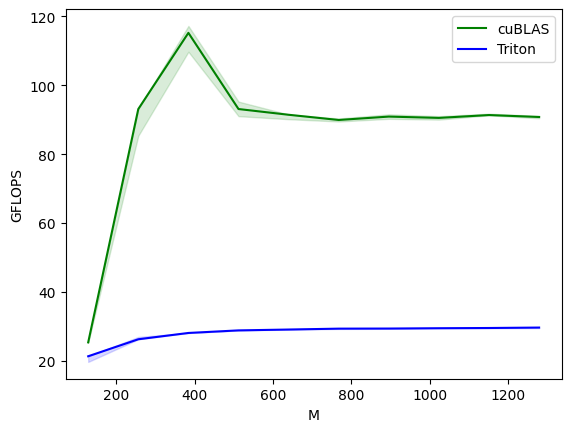

ternary-mul-2d2d-performance:
        M       N      cuBLAS     Triton
0   128.0   128.0   25.362230  21.333333
1   256.0   256.0   93.090908  26.266935
2   384.0   384.0  115.200003  28.097561
3   512.0   512.0   93.090908  28.845070
4   640.0   640.0   91.428569  29.090909
5   768.0   768.0   89.912200  29.350318
6   896.0   896.0   90.898549  29.377050
7  1024.0  1024.0   90.519339  29.467627
8  1152.0  1152.0   91.348019  29.538462
9  1280.0  1280.0   90.780144  29.663963


In [164]:
REF_LIB = "cuBLAS"
K = 8

configs = [
    triton.testing.Benchmark(
        x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 11)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=[REF_LIB.lower(), "triton"],  # Label name for the lines
        line_names=[REF_LIB, "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GFLOPS",  # Label name for the y-axis
        plot_name="ternary-mul-2d2d-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
]

@triton.testing.perf_report(configs)
def benchmark(M, N, provider):
    print(f"Trial when K = {K}, M = {M}, and N = {N}, for {provider}")
    a = torch.rand((M, K), device="cuda")
    w = torch.tensor([-1.0, 0.0, 1.0], device="cuda")[torch.randint(2, (K, N))]
    scale = torch.rand(1, dtype=torch.float32).item()

    quantiles = [0.5, 0.2, 0.8]
    if provider == REF_LIB.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, w) / scale, quantiles=quantiles)
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: ternary_mul_2d2d(a, w, scale), quantiles=quantiles)
    gflops = lambda ms: 2 * K * M * N * 1e-9 / (ms * 1e-3)
    return gflops(ms), gflops(max_ms), gflops(min_ms)


benchmark.run(show_plots=True, print_data=True)

## 3D Ternary Multiplication Kernel

The autotune config should be similar to the 2D case.

In [ ]:
# def get_autotune_config_3d():
#     if is_cuda():
#         return _get_autotune_config_2d()
#     else:
#         raise ValueError("Not on CUDA... can't use!")

The kernel's rough pseudocode algorithm is as follows.
```python
k = 0  # Output vector pointer

# Do in parallel
for i in range(0, num_elem_per_matrix, matrix_stride):
    # Do in parallel
    for j in range(0, num_elem_per_vector, vector_stride):
        matrix_elements = w_flat[i : i+matrix_stride].reshape(matrix_shape)
        vector_elements = x_flat[j : j+vector_stride]
        product = _2d_ternary_multiplication(vector_elements, matrix_elements, scale)
        output_flat[k : k+output_stride] = product
        k += output_stride

return output_flat.reshape(output_shape)
```

Note that `matrix_stride` and `vector_stride` may not be power-of-two values. Thus we will employ padding to ensure that achieve this, but using a mask to ensure that we don't get memory access errors.

In [ ]:
# # ruff: noqa: N803, PLR2044
# @triton.autotune(
#     configs=get_autotune_config_3d(),
#     key=["M", "N"],
# )
# @triton.jit
# def ternary_mul_3d_kernel(
#     # Pointers to arrays
#     x_ptr,
#     w_ptr,
#     z_ptr,
#     # Scaling factor
#     scale,
#     # `W` matrix dimensions
#     K: tl.constexpr,
#     M: tl.constexpr,
#     N: tl.constexpr,
#     # Strides
#     stride_xk,
#     stride_xm,
#     stride_wk,
#     stride_wm,
#     stride_wn,
#     # Meta-parameters
#     BLOCK_SIZE_M: tl.constexpr,
#     BLOCK_SIZE_N: tl.constexpr,
# ):
#     """
#     Kernel for computing the batched ternary multiplication
#         z = xW
#     `x` has shape `(K, M)`, `W` has shape `(K, M, N)`, and `z` has shape `(K, K, N)`.
#     """

#     # -----------------------------------------------------------
#     # Map `pid` to the correct `x` vector and `W` matrix blocks that we are computing
#     pid_0 = tl.program_id(axis=0)
#     pid_1 = tl.program_id(axis=1)

#     pid_x = pid_1 % K
#     pid_w = pid_1 // K

#     # ----------------------------------------------------------
#     # Create pointers for the `x` vector and `W` matrix
#     offs_m = tl.arange(0, BLOCK_SIZE_M)
#     offs_n = (pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N  # Guard against wrong offsets

#     x_ptrs = x_ptr + pid_x * stride_xk + offs_m
#     w_ptrs = w_ptr + pid_w * stride_wk + (offs_m[:, None] * stride_wm + offs_n[None, :] * stride_wn)

#     # -----------------------------------------------------------
#     # Iterate to compute a block of the `z` vector.
#     # We accumulate into a block of `BLOCK_SIZE_N` elements of FP32 values for higher accuracy.
#     accumulator = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)

#     for m in range(0, tl.cdiv(M, BLOCK_SIZE_M)):
#         # Load the next block of `x` and `W`, generate a mask by checking along `M`.
#         # If it is out of bounds, set it to 0.
#         x = tl.load(x_ptrs, mask=offs_m < M - m * BLOCK_SIZE_M, other=0.0)[:, None]  # Force broadcast to correct shape
#         w = tl.load(w_ptrs, mask=offs_m[:, None] < M - m * BLOCK_SIZE_M, other=0.0)

#         # Since `w` is ternary, we only really care about the sign of the element in the array, and so  we just need to
#         # perform two conditional checks
#         elements_to_sum = tl.where(w > 0, x, tl.where(w < 0, -x, tl.zeros_like(x)))
#         accumulator = accumulator + tl.sum(elements_to_sum, axis=0)  # Sum along the `M` direction

#         # Advance the ptrs to the next `M` block.
#         x_ptrs += BLOCK_SIZE_M * stride_xm
#         w_ptrs += BLOCK_SIZE_M * stride_wm

#     z = accumulator / scale  # TODO: Do we want to reduce precision back to FP16?

#     # -----------------------------------------------------------
#     # Write back the block of the output vector `z` with masks
#     offs_z = pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
#     z_ptrs = z_ptr + pid_1 * N + offs_z
#     z_mask = offs_z < N
#     tl.store(z_ptrs, z, mask=z_mask)

Create a convenience wrapper function that handles the checks and kernel calling.

In [ ]:
# # ruff: noqa: E731, S101, N806
# def ternary_mul_3d(x, w, scale):
#     # Check constraints
#     assert w.ndim == 3, "Weight matrix does not have suitable dimensionality"
#     assert x.shape[-1] == w.shape[-2], "Incompatible dimensions"
#     assert x.shape[0] == w.shape[0], "Incompatible batch sizes"
#     assert x.is_contiguous(), "x must be contiguous"
#     assert x.is_cuda and w.is_cuda

#     # Get dimensions
#     K, M, N = w.shape

#     # Allocate output
#     z = torch.zeros((K, K, N), device=x.device)

#     # 2D launch kernel
#     grid = lambda META: (triton.cdiv(N, META["BLOCK_SIZE_N"]), K * K)

#     # fmt: off
#     ternary_mul_3d_kernel[grid](
#         x, w, z,
#         scale,
#         K, M, N,
#         x.stride(0), x.stride(1), w.stride(0), w.stride(1), w.stride(2)
#     )
#     # fmt: on

#     return z

In [ ]:
# X_SHAPE = (3, 5)     # x is the vector
# W_SHAPE = (3, 5, 7)  # W is the quantized weights matrix

In [ ]:
# torch.manual_seed(8192)

In [ ]:
# x = torch.rand(X_SHAPE, device="cuda", dtype=torch.float32)
# w = torch.tensor([-1., 0., 1.], device="cuda", dtype=torch.float32)[torch.randint(2, W_SHAPE)]
# scale = torch.rand(1, dtype=torch.float32).item()

In [ ]:
# torch_output = torch.matmul(x, w) / scale
# print(torch_output)

In [ ]:
# triton_output = ternary_mul_3d(x, w, scale)
# print(triton_output)

In [ ]:
# if torch.allclose(triton_output, torch_output, atol=1e-3):
#     print("✅ Triton and Torch match")
# else:
#     raise ValueError("❌ Triton and Torch differ")

Benchmark the Triton kernel against the standard Torch implementation of matmul.

In [ ]:
# ref_lib = "cuBLAS"
# K = 4

# configs = [
#     triton.testing.Benchmark(
#         x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
#         x_vals=[128 * i for i in range(11, 16)],  # Different possible values for `x_name`
#         line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
#         # Possible values for `line_arg`
#         line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
#         line_names=[ref_lib, "Triton"],  # Line styles
#         styles=[("green", "-"), ("blue", "-")],
#         ylabel="GFLOPS",  # Label name for the y-axis
#         plot_name="ternary-mul-3d-performance",  # Name for the plot, used also as a file name for saving the plot.
#         args={},
#     )
# ]

# @triton.testing.perf_report(configs)
# def benchmark(M, N, provider):
#     print(f"Trial when K = {K}, M = {M}, N = {N}, for {provider}")
#     x = torch.rand((K, M), device="cuda")
#     w = torch.tensor([-1.0, 0.0, 1.0], device="cuda")[torch.randint(2, (K, M, N))]
#     scale = torch.rand(1, dtype=torch.float32).item()

#     quantiles = [0.5, 0.2, 0.8]
#     if provider == ref_lib.lower():
#         ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(x, w) / scale, quantiles=quantiles)
#     if provider == "triton":
#         ms, min_ms, max_ms = triton.testing.do_bench(lambda: ternary_mul_3d(x, w, scale), quantiles=quantiles)
#     gflops = lambda ms: 2 * K * M * N * 1e-9 / (ms * 1e-3)
#     return gflops(ms), gflops(max_ms), gflops(min_ms)


# benchmark.run(show_plots=True, print_data=True)

## Generalized Ternary Multiplication Kernel (DOES NOT WORK FOR 4D AND ABOVE)

The autotune config should be similar to the 2D case.

In [ ]:
# def get_autotune_config():
#     if is_cuda():
#         return _get_autotune_config_2d()
#     else:
#         raise ValueError("Not on CUDA... can't use!")

The kernel's rough pseudocode algorithm is as follows.
```python
k = 0  # Output vector pointer

# Do in parallel
for i in range(0, num_elem_per_matrix, matrix_stride):
    # Do in parallel
    for j in range(0, num_elem_per_vector, vector_stride):
        matrix_elements = w_flat[i : i+matrix_stride].reshape(matrix_shape)
        vector_elements = x_flat[j : j+vector_stride]
        product = _2d_ternary_multiplication(vector_elements, matrix_elements, scale)
        output_flat[k : k+output_stride] = product
        k += output_stride

return output_flat.reshape(output_shape)
```

Note that `matrix_stride` and `vector_stride` may not be power-of-two values. Thus we will employ padding to ensure that achieve this, but using a mask to ensure that we don't get memory access errors.

In [ ]:
# # ruff: noqa: N803, PLR2044
# @triton.autotune(
#     configs=get_autotune_config(),
#     key=["M", "N"],
# )
# @triton.jit
# def ternary_mul_kernel(
#     # Pointers to arrays
#     x_ptr,
#     w_ptr,
#     z_ptr,
#     # Scaling factor
#     scale,
#     # # `W` matrix dimensions
#     M: tl.constexpr,
#     N: tl.constexpr,
#     # Strides
#     matrix_stride,
#     vector_stride,
#     stride_xm,
#     stride_wm,
#     stride_wn,
#     # Counts of matrices and vectors
#     num_stacked_matrices,
#     num_stacked_vectors,
#     # Meta-parameters
#     BLOCK_SIZE_M: tl.constexpr,
#     BLOCK_SIZE_N: tl.constexpr,
# ):
#     """
#     Kernel for computing the ternary multiplication
#         z = xW
#     `x` has shape `(..., M)`, `W` has shape `(..., M, N)`, and `z` has shape `(..., N)`.
#     """

#     # -----------------------------------------------------------
#     # Map `pid` to the correct `x` vector and `W` matrix blocks that we are computing
#     pid_0 = tl.program_id(axis=0)
#     pid_1 = tl.program_id(axis=1)
    
#     pid_vector = pid_1 % num_stacked_vectors
#     pid_matrix = pid_1 // num_stacked_vectors
    
#     # ----------------------------------------------------------
#     # Create pointers for the `x` vector and `W` matrix
#     offs_m = tl.arange(0, BLOCK_SIZE_M)
#     offs_n = (pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N  # Guard against wrong offsets

#     offs_x = pid_vector * vector_stride + offs_m
#     offs_w = pid_matrix * matrix_stride + (offs_m[:, None] * stride_wm + offs_n[None, :] * stride_wn)
    
#     x_ptrs = x_ptr + offs_x
#     w_ptrs = w_ptr + offs_w
    
#     # -----------------------------------------------------------
#     # Iterate to compute a block of the `z` vector.
#     # We accumulate into a block of `BLOCK_SIZE_N` elements of FP32 values for higher accuracy.
#     accumulator = tl.zeros((BLOCK_SIZE_N,), dtype=tl.float32)

#     for m in range(0, tl.cdiv(M, BLOCK_SIZE_M)):
#         # Load the next block of `x` and `W`, generate a mask by checking along `M`.
#         # If it is out of bounds, set it to 0.
#         x = tl.load(x_ptrs, mask=offs_m < M - m * BLOCK_SIZE_M, other=0.0)[:, None]  # Force broadcast to correct shape
#         w = tl.load(w_ptrs, mask=offs_m[:, None] < M - m * BLOCK_SIZE_M, other=0.0)

#         # Since `w` is ternary, we only really care about the sign of the element in the array, and so  we just need to
#         # perform two conditional checks
#         elements_to_sum = tl.where(w > 0, x, tl.where(w < 0, -x, tl.zeros_like(x)))
#         accumulator = accumulator + tl.sum(elements_to_sum, axis=0)  # Sum along the `M` direction

#         # Advance the ptrs to the next `M` block.
#         x_ptrs += BLOCK_SIZE_M * stride_xm
#         w_ptrs += BLOCK_SIZE_M * stride_wm

#     z = accumulator / scale  # TODO: Do we want to reduce precision back to FP16?

#     # -----------------------------------------------------------
#     # Write back the block of the output vector `z` with masks
#     offs_z = pid_0 * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
#     z_ptrs = z_ptr + pid_1 * N + offs_z
#     z_mask = offs_z < N
#     tl.store(z_ptrs, z, mask=z_mask)

Create a convenience wrapper function that handles the checks and kernel calling.

In [ ]:
# # ruff: noqa: E731, S101, N806
# def ternary_mul(x, w, scale):
#     # Check constraints
#     assert x.ndim == w.ndim - 1, "Incompatible dimensionality"
#     assert x.shape[-1] == w.shape[-2], "Incompatible dimensions"
#     assert x.is_contiguous(), "x must be contiguous"

#     assert x.is_cuda and w.is_cuda

#     # Otherwise, we need to treat what we have as a stack of matrices.
#     # First we get the number of stacked matrices and vectors that we need to process
#     w_shape = w.shape
#     x_shape = x.shape

#     num_stacked_matrices = 1
#     num_stacked_vectors = 1
#     for i in range(w.ndim - 2):  # The last 2 indices are the matrices
#         num_stacked_matrices *= w_shape[i]
#         num_stacked_vectors *= x_shape[i]

#     # Identify the shape of the matrices and vectors that will actually be multiplied
#     matrix_shape = (w_shape[-2], w_shape[-1])
#     matrix_stride = w_shape[-2] * w_shape[-1]
#     vector_stride = x_shape[-1]
    
#     # Get dimensions
#     M, N = w_shape[-2], w_shape[-1]

#     # Determine output size and shape
#     if w.ndim == 2:
#         output_shape = [w_shape[-1]]
#         num_processes = 1  # No need for 2D launch grid
#     else:
#         output_shape = [*list(w_shape[:-2]), x_shape[-2], w_shape[-1]]
#         num_processes = num_stacked_matrices * x_shape[-2]
#     output = torch.zeros(output_shape, device=x.device)
    
#     # 2D launch kernel
#     grid = lambda META: (triton.cdiv(N, META["BLOCK_SIZE_N"]), num_processes)
    
#     # fmt: off
#     ternary_mul_kernel[grid](
#         x, w, output,
#         scale,
#         M, N,
#         matrix_stride, vector_stride, x.stride(-1), w.stride(-2), w.stride(-1),
#         num_stacked_matrices, num_stacked_vectors
#     )
#     # fmt: on

#     return output

Test the kernel.

In [ ]:
# # X_SHAPE = (   3, 3, 1)  # x is the vector
# # W_SHAPE = (3, 3, 1, 2)  # W is the quantized weights matrix
# X_SHAPE = (3, 1)  # x is the vector
# W_SHAPE = (3, 1, 2)  # W is the quantized weights matrix

In [ ]:
# torch.manual_seed(8192)

In [ ]:
# x = torch.rand(X_SHAPE, device="cuda", dtype=torch.float32)
# w = torch.tensor([-1., 0., 1.], device="cuda", dtype=torch.float32)[torch.randint(2, W_SHAPE)]
# scale = torch.rand(1, dtype=torch.float32).item()

In [ ]:
# torch_output = torch.matmul(x, w) / scale
# print(torch_output)

In [ ]:
# triton_output = ternary_mul(x, w, scale)
# print(triton_output)

In [ ]:
# if torch.allclose(triton_output, torch_output, atol=1e-3):
#     print("✅ Triton and Torch match")
# else:
#     raise ValueError("❌ Triton and Torch differ")

In [ ]:
# ref_lib = "cuBLAS"
# K = 8

# configs = [
#     triton.testing.Benchmark(
#         x_names=["M", "N"],  # Argument names to use as an x-axis for the plot
#         x_vals=[128 * i for i in range(1, 11)],  # Different possible values for `x_name`
#         line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
#         # Possible values for `line_arg`
#         line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
#         line_names=[ref_lib, "Triton"],  # Line styles
#         styles=[("green", "-"), ("blue", "-")],
#         ylabel="GFLOPS",  # Label name for the y-axis
#         plot_name="ternary-mul-general-performance",  # Name for the plot, used also as a file name for saving the plot.
#         args={},
#     )
# ]

# @triton.testing.perf_report(configs)
# def benchmark(M, N, provider):
#     print(f"Trial when K = {K}, M = {M}, N = {N}, for {provider}")
#     x = torch.rand((K, M), device="cuda")
#     w = torch.tensor([-1.0, 0.0, 1.0], device="cuda")[torch.randint(2, (K, M, N))]
#     scale = torch.rand(1, dtype=torch.float32).item()

#     quantiles = [0.5, 0.2, 0.8]
#     if provider == ref_lib.lower():
#         ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(x, w) / scale, quantiles=quantiles)
#     if provider == "triton":
#         ms, min_ms, max_ms = triton.testing.do_bench(lambda: ternary_mul(x, w, scale), quantiles=quantiles)
#     gflops = lambda ms: 2 * K * M * N * 1e-9 / (ms * 1e-3)
#     return gflops(ms), gflops(max_ms), gflops(min_ms)


# benchmark.run(show_plots=True, print_data=True)